# ML & Generating Predictions Notebook 03
This notebook is where we will evaluate baseline and candidate models to see which model we should use as our primary.  

*Note: We did not perform feature selection because the dataset contains only twelve clinically meaningful features, and removing any of them could discard useful non-linear or interaction effects. Simple correlation is not a reliable indicator of predictive value, especially in medical data. Several models we use, including Random Forests, Gradient Boosting, and regularized Logistic Regression, already perform built-in feature selection or regularization by down-weighting weaker predictors. Because these models naturally handle feature relevance, explicit feature elimination is unnecessary for this project. We will analyze feature importance in a future step* 

In [3]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# XGBoost and LightGBM
import xgboost as xgb
from xgboost import XGBClassifier


import lightgbm as lgb
from lightgbm import LGBMClassifier


# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    roc_curve,
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)

# Set plot style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Set random seed for reproducibility
np.random.seed(42)


In [39]:
# Results Dict
all_results = {}

### We will create a baseline logistic regression for our actual models to outperform

In [4]:
continuous_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

In [11]:
# Load data - splits were created in previous notebook 
X_train = pd.read_csv("../data/X_train.csv")
y_train = pd.read_csv("../data/y_train.csv").values.ravel()  # Convert to 1D array

X_val = pd.read_csv("../data/X_val.csv")
y_val = pd.read_csv("../data/y_val.csv").values.ravel()  # Convert to 1D array

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in validation: {np.bincount(y_val)}")

Training set: 179 samples
Validation set: 45 samples
Class distribution in training: [130  49]
Class distribution in validation: [33 12]


In [13]:
# create pipeline and run logistic regression

# Column Transformer + Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

# Example pipeline with logistic regression, will redo this part in the ML notebook
baseline_lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear',class_weight='balanced'))]
)

In [14]:
# Train the baseline model
baseline_lr_pipeline.fit(X_train, y_train)

# Make predictions on VALIDATION set
y_val_pred = baseline_lr_pipeline.predict(X_val)
y_val_pred_proba = baseline_lr_pipeline.predict_proba(X_val)[:, 1]  # Probability of death

print("Baseline Logistic Regression trained successfully!")


Baseline Logistic Regression trained successfully!


In [18]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    """
    Comprehensive evaluation function for binary classification.
    
    Prints:
    1. Accuracy - Overall correctness (misleading with imbalance)
    2. Recall (Sensitivity) - How well we catch deaths (MOST IMPORTANT clinically)
    3. Precision - Of predicted deaths, how many are real
    4. F1 Score - Harmonic mean of precision and recall
    5. ROC-AUC - Best single metric for ranking ability
    6. Confusion Matrix - Breakdown of predictions
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels (0 or 1)
    y_pred_proba : array-like
        Predicted probabilities for positive class
    model_name : str
        Name of the model for display
    """
    print("="*70)
    print(f"EVALUATION METRICS: {model_name}")
    print("="*70)
    
    # 1. ACCURACY
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("Easy to interpret, but misleading with class imbalance")
    print("A model predicting all 'survived' would get ~73% accuracy!")
    
    # 2. RECALL (SENSITIVITY) - Most important clinically!
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    print(f"\nRECALL (Sensitivity): {recall:.4f} ({recall*100:.2f}%)")
    print("MOST IMPORTANT METRIC CLINICALLY")
    print("Of all patients who died, what % did we correctly identify?")
    print(f"We caught {recall*100:.1f}% of actual deaths")
    
    # 3. PRECISION
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    print(f"\nPRECISION: {precision:.4f} ({precision*100:.2f}%)")
    print("Of all predicted deaths, what % were correct?")
    print(f"{precision*100:.1f}% of predicted deaths were real")
    
    # 4. F1 SCORE
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    print(f"\nF1 SCORE: {f1:.4f}")
    print("Harmonic mean of precision and recall")
    print("Good summary for imbalanced classification")
    print(f"Majority baseline: F1 = 0.0 (predicts no deaths)")
    
    # 5. ROC-AUC
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    print(f"\nROC-AUC: {roc_auc:.4f}")
    print("Measures ranking ability (0.5 = random, 1.0 = perfect)")

    
    # 6. CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nCONFUSION MATRIX:")
    print("="*50)
    print(f"True Negatives (TN):  {tn:4d}  | Correctly predicted survived")
    print(f"False Positives (FP): {fp:4d}  | Incorrectly predicted death")
    print(f"False Negatives (FN): {fn:4d}  | MISSED deaths ")
    print(f"True Positives (TP):  {tp:4d}  | Correctly predicted death")
    print("="*50)
    print(f"Total Predictions: {tn + fp + fn + tp}")
    print(f"Actual Deaths: {fn + tp} | Actual Survived: {tn + fp}")
    
    # Visualization
    print("\nVisual Confusion Matrix:")
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ConfusionMatrixDisplay(cm, display_labels=['Survived', 'Died']).plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix: {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n" + "="*50)
    print("SUMMARY:")
    print(f"Accuracy: {accuracy:.3f} | Recall: {recall:.3f} | Precision: {precision:.3f}")
    print(f"F1 Score: {f1:.3f} | ROC-AUC: {roc_auc:.3f}")
    print(f"Missed Deaths (FN): {fn} out of {fn+tp} ({fn/(fn+tp)*100:.1f}%)")
    print("="*50 + "\n")


EVALUATION METRICS: Baseline Logistic Regression

ACCURACY: 0.7556 (75.56%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.5833 (58.33%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 58.3% of actual deaths

PRECISION: 0.5385 (53.85%)
Of all predicted deaths, what % were correct?
53.8% of predicted deaths were real

F1 SCORE: 0.5600
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.8409
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    27  | Correctly predicted survived
False Positives (FP):    6  | Incorrectly predicted death
False Negatives (FN):    5  | MISSED deaths 
True Positives (TP):     7  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusio

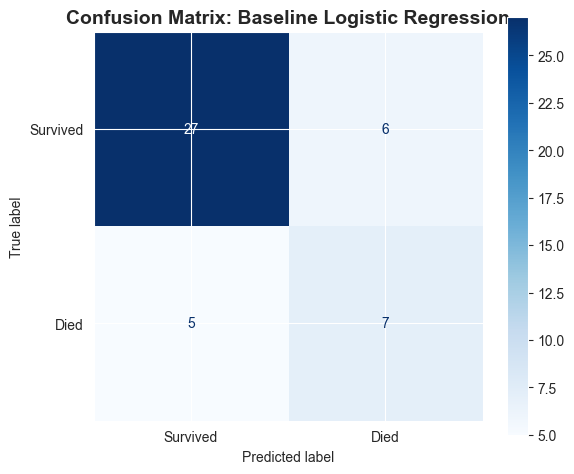


SUMMARY:
Accuracy: 0.756 | Recall: 0.583 | Precision: 0.538
F1 Score: 0.560 | ROC-AUC: 0.841
Missed Deaths (FN): 5 out of 12 (41.7%)



In [19]:
# Evaluate the Baseline Logistic Regression
evaluate_model(y_val, y_val_pred, y_val_pred_proba, model_name="Baseline Logistic Regression")


In [20]:
def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
    """
    Plot ROC curve for a single model.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_proba : array-like
        Predicted probabilities for positive class
    model_name : str
        Name of the model for display
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title(f'ROC Curve: {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return roc_auc


def plot_multiple_roc_curves(models_dict, y_true):
    """
    Plot multiple ROC curves on the same plot for comparison.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with format: {'Model Name': y_pred_proba, ...}
    y_true : array-like
        True labels
    """
    plt.figure(figsize=(10, 8))
    
    colors = ['darkorange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i, (model_name, y_pred_proba) in enumerate(models_dict.items()):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        color = colors[i % len(colors)]
        plt.plot(fpr, tpr, lw=2, color=color, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


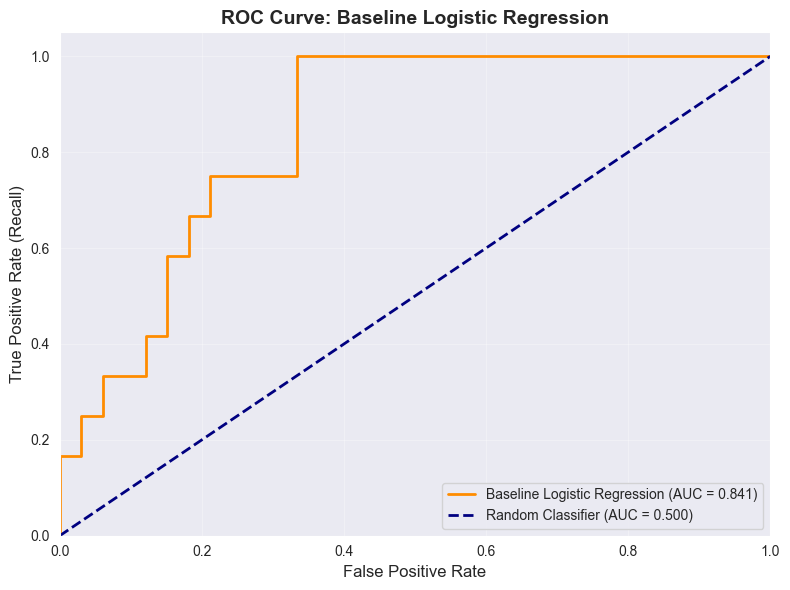

0.8409090909090909

In [21]:
# Plot ROC curve for baseline logistic regression
plot_roc_curve(y_val, y_val_pred_proba, model_name="Baseline Logistic Regression")


### Now we will use more complex models 

Notes:  
- We used 5-fold stratified cross-validation for model selection because the dataset is relatively small (299 samples). Five folds provide a good balance between bias and variance, produce stable performance estimates, and avoid the computational cost of higher-fold CV while still giving more reliable results than a single train/validation split.
- We will use GridSearchCV to return the best model for each and to tune hyperparameters

### Logistic Regression
We will begin with logistic regression. We will: 
- Tune the regularization strength of logistic regression using GridSearchCV over C ∈ {0.01, 0.1, 1, 10, 100} with 5-fold cross-validation and ROC–AUC as the scoring metric.
- Selected the C_i that produced the highest mean cross-validated ROC-AUC on thr training set.
- Refit the model with optimal C

In [52]:
# Set up the pipeline 
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000, random_state=42,penalty='l2'))
])

# Define the hyperparameter grid - trying different regularization strengths
c_vals = [i * 0.0001 for i in range(1, 15)]
c_vals.append(0.01)
c_vals.append(0.1)
param_grid = {
    'classifier__C': c_vals  # Lower C = stronger regularization
}

print(f"Testing {len(c_vals)} different C values with 5-fold CV")

# Setup 5-fold cross validation (stratified to keep class balance in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV - this will try all C values and pick the best one
grid_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Most important metric for us
    n_jobs=-1,  # Use all CPU cores
    verbose=0
)

# Fit - this runs all the cross-validation
grid_search.fit(X_train, y_train)

print("\nGrid search complete!")


Testing 16 different C values with 5-fold CV

Grid search complete!


In [44]:
print("Best parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validated ROC-AUC score: {grid_search.best_score_:.4f}")

# Look at all the results to see how each C performed
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nAll cross-validation results:")
print(results_df[['param_classifier__C', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))


Best parameters found:
{'classifier__C': 0.0012000000000000001}

Best cross-validated ROC-AUC score: 0.9109

All cross-validation results:
    param_classifier__C  mean_test_score  std_test_score
11               0.0012         0.910940        0.044627
12               0.0013         0.910940        0.044627
13               0.0014         0.910940        0.044627
9                0.0010         0.909231        0.043961
10               0.0011         0.909231        0.043961
8                0.0009         0.908462        0.045469
0                0.0001         0.908376        0.042069
1                0.0002         0.908376        0.042069
2                0.0003         0.907607        0.043560
3                0.0004         0.907607        0.043560
5                0.0006         0.907607        0.045226
6                0.0007         0.907607        0.045226
7                0.0008         0.907607        0.045226
4                0.0005         0.906838        0.045054
14    

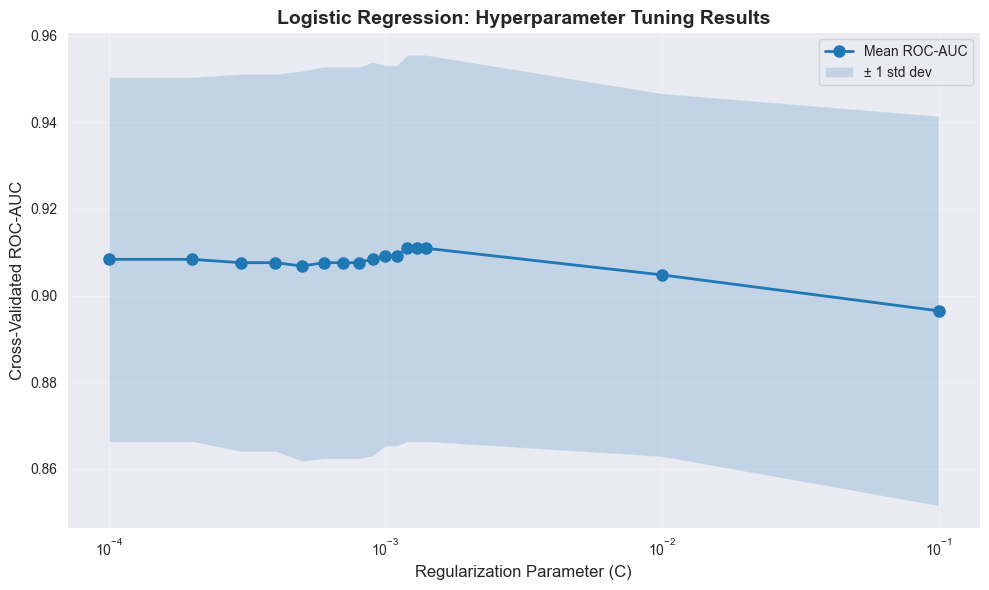

In [45]:
# Visualize how performance changes with C
plt.figure(figsize=(10, 6))
mean_scores = results_df['mean_test_score'].values
std_scores = results_df['std_test_score'].values

plt.semilogx(c_vals, mean_scores, 'o-', linewidth=2, markersize=8, label='Mean ROC-AUC')
plt.fill_between(c_vals, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, label='± 1 std dev')
plt.xlabel('Regularization Parameter (C)', fontsize=12)
plt.ylabel('Cross-Validated ROC-AUC', fontsize=12)
plt.title('Logistic Regression: Hyperparameter Tuning Results', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Interesting to see - lower C means more regularization (simpler model)
# Higher C means less regularization (more complex model)


In [47]:
# The best model is already refitted on the full training set by GridSearchCV
# We can access it directly
tuned_lr_model = grid_search.best_estimator_

# Make predictions on validation set
y_val_pred_tuned = tuned_lr_model.predict(X_val)
y_val_pred_proba_tuned = tuned_lr_model.predict_proba(X_val)[:, 1]

print("Tuned Logistic Regression ready for evaluation!")


Tuned Logistic Regression ready for evaluation!


EVALUATION METRICS: Tuned Logistic Regression

ACCURACY: 0.8000 (80.00%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.9167 (91.67%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 91.7% of actual deaths

PRECISION: 0.5789 (57.89%)
Of all predicted deaths, what % were correct?
57.9% of predicted deaths were real

F1 SCORE: 0.7097
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.8712
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    25  | Correctly predicted survived
False Positives (FP):    8  | Incorrectly predicted death
False Negatives (FN):    1  | MISSED deaths 
True Positives (TP):    11  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusion M

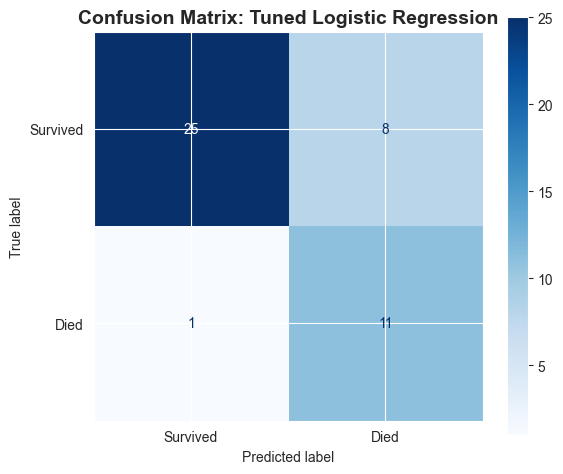


SUMMARY:
Accuracy: 0.800 | Recall: 0.917 | Precision: 0.579
F1 Score: 0.710 | ROC-AUC: 0.871
Missed Deaths (FN): 1 out of 12 (8.3%)



In [48]:
# Evaluate the tuned model
evaluate_model(y_val, y_val_pred_tuned, y_val_pred_proba_tuned, model_name="Tuned Logistic Regression")


COMPARISON: Baseline vs Tuned Logistic Regression
  Metric  Baseline LR  Tuned LR  Improvement
 ROC-AUC     0.840909  0.871212     0.030303
  Recall     0.583333  0.916667     0.333333
F1 Score     0.560000  0.709677     0.149677


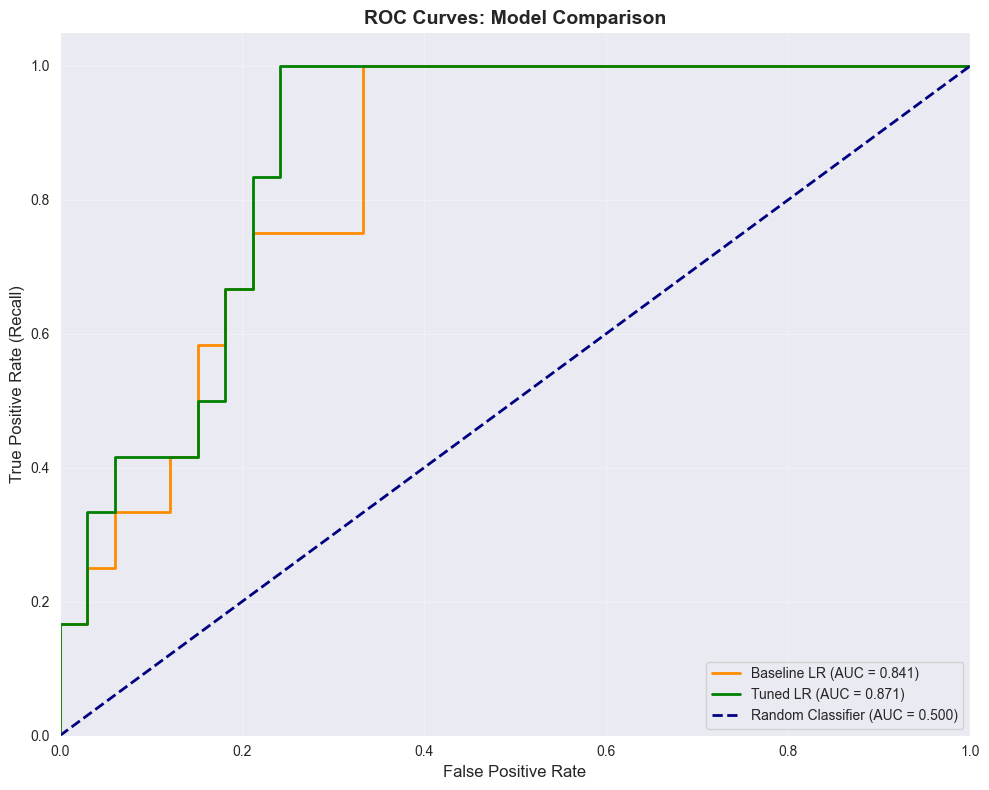

In [49]:
# Compare baseline vs tuned logistic regression
print("="*70)
print("COMPARISON: Baseline vs Tuned Logistic Regression")
print("="*70)

# Calculate metrics for both
baseline_auc = roc_auc_score(y_val, y_val_pred_proba)
tuned_auc = roc_auc_score(y_val, y_val_pred_proba_tuned)

baseline_recall = recall_score(y_val, y_val_pred, pos_label=1)
tuned_recall = recall_score(y_val, y_val_pred_tuned, pos_label=1)

baseline_f1 = f1_score(y_val, y_val_pred, pos_label=1)
tuned_f1 = f1_score(y_val, y_val_pred_tuned, pos_label=1)

comparison = pd.DataFrame({
    'Metric': ['ROC-AUC', 'Recall', 'F1 Score'],
    'Baseline LR': [baseline_auc, baseline_recall, baseline_f1],
    'Tuned LR': [tuned_auc, tuned_recall, tuned_f1],
    'Improvement': [tuned_auc - baseline_auc, tuned_recall - baseline_recall, tuned_f1 - baseline_f1]
})

print(comparison.to_string(index=False))
print("="*70)

# Plot ROC curves side by side
models_dict = {
    'Baseline LR': y_val_pred_proba,
    'Tuned LR': y_val_pred_proba_tuned
}
plot_multiple_roc_curves(models_dict, y_val)


In [50]:
# Store results for later comparison with other models
lr_results = {
    'model_name': 'Logistic Regression (Tuned)',
    'model': tuned_lr_model,
    'y_pred': y_val_pred_tuned,
    'y_pred_proba': y_val_pred_proba_tuned,
    'roc_auc': tuned_auc,
    'recall': tuned_recall,
    'f1': tuned_f1,
    'best_params': grid_search.best_params_
}

all_results['Logistic Regression (Tuned)'] = lr_results
print("Saved results for LR (Tuned)")


Saved results for LR (Tuned)


### Decision Trees
We will follow the same structure from above. We will use GridSearchCV to run cross validation as well as find optimal hyperparameters

In [78]:
# Init Pipeline
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Define Hyperparameter Grid
param_grid = {
    'classifier__max_depth': [2, 3, 4, 5, 7, 9, 11, 13, 15, None],    
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

In [82]:
# Setup 5-fold cross validation (stratified to keep class balance in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch
grid_dt = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit - this runs all the cross-validation
grid_dt.fit(X_train, y_train)

print("\nGrid search complete!")



Grid search complete!


In [83]:
print("Best params:", grid_dt.best_params_)
print("Best ROC-AUC:", grid_dt.best_score_)

Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best ROC-AUC: 0.8491880341880341


In [84]:
# Let's look at all results
results_df = pd.DataFrame(grid_dt.cv_results_)
print("\nAll cross-validation results:")
print(results_df[['param_classifier__max_depth', 'param_classifier__min_samples_split', 'param_classifier__min_samples_leaf' ,'param_classifier__min_samples_leaf','param_classifier__criterion', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))


All cross-validation results:
    param_classifier__max_depth  param_classifier__min_samples_split  \
116                           4                                   10   
114                           4                                    2   
115                           4                                    5   
5                             2                                   10   
1                             2                                    5   
..                          ...                                  ...   
54                           11                                    2   
45                            9                                    2   
21                            4                                    2   
22                            4                                    5   
36                            7                                    2   

     param_classifier__min_samples_leaf  param_classifier__min_samples_leaf  \
116                      

EVALUATION METRICS: Tuned Decision Tree

ACCURACY: 0.8444 (84.44%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.7500 (75.00%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 75.0% of actual deaths

PRECISION: 0.6923 (69.23%)
Of all predicted deaths, what % were correct?
69.2% of predicted deaths were real

F1 SCORE: 0.7200
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.8144
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    29  | Correctly predicted survived
False Positives (FP):    4  | Incorrectly predicted death
False Negatives (FN):    3  | MISSED deaths 
True Positives (TP):     9  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusion Matrix:

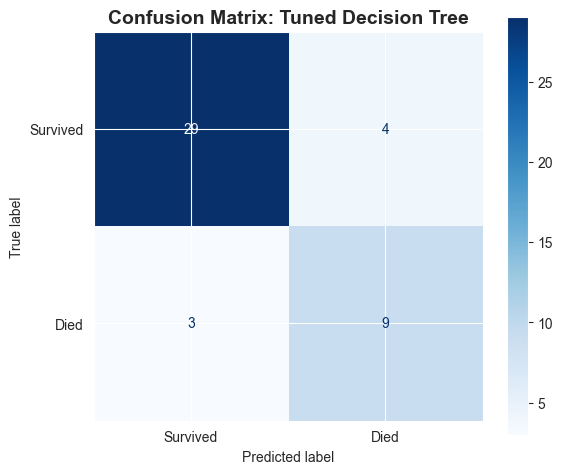


SUMMARY:
Accuracy: 0.844 | Recall: 0.750 | Precision: 0.692
F1 Score: 0.720 | ROC-AUC: 0.814
Missed Deaths (FN): 3 out of 12 (25.0%)



In [85]:
tuned_dt_model = grid_dt.best_estimator_

# Make predictions on validation set
y_val_pred_tuned_dt = tuned_dt_model.predict(X_val)
y_val_pred_proba_tuned_dt = tuned_dt_model.predict_proba(X_val)[:, 1]

# Evaluate the tuned model
evaluate_model(y_val, y_val_pred_tuned_dt, y_val_pred_proba_tuned_dt, model_name="Tuned Decision Tree")



COMPARISON: Baseline vs Tuned Decision Tree
  Metric  Baseline DT  Tuned DT  Improvement
 ROC-AUC     0.840909  0.814394    -0.026515
  Recall     0.583333  0.750000     0.166667
F1 Score     0.560000  0.720000     0.160000


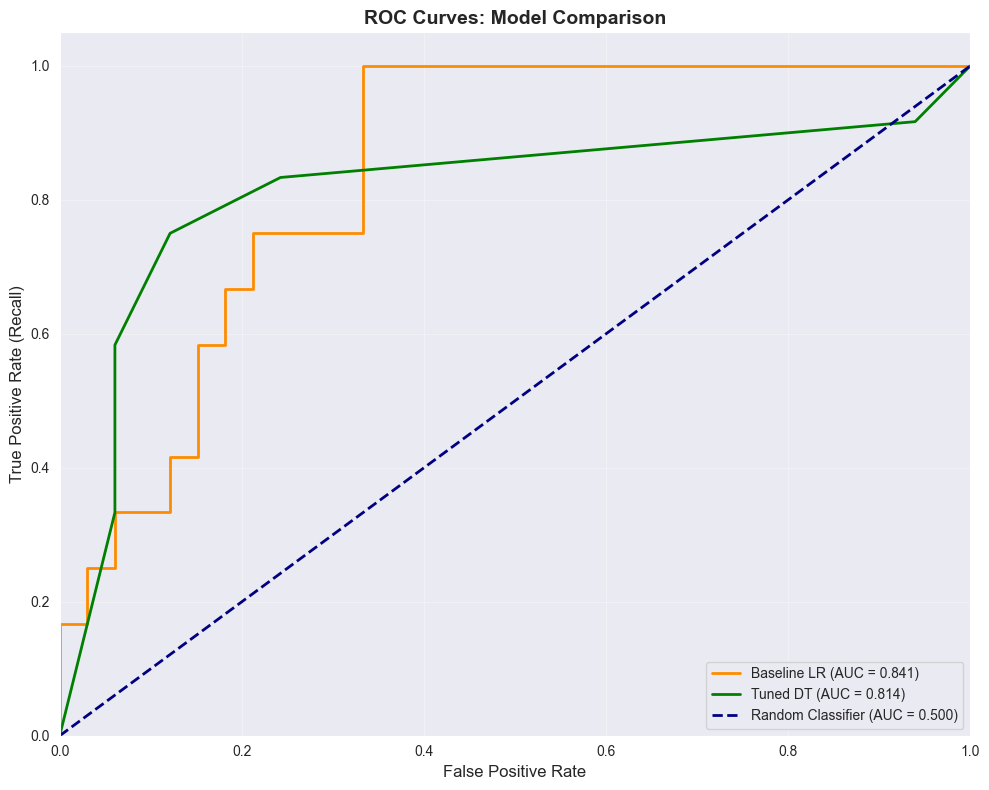

In [ ]:
# Compare baseline vs tuned Decision Tree
print("="*70)
print("COMPARISON: Baseline vs Tuned Decision Tree")
print("="*70)

# Calculate metrics 
tuned_dt_auc = roc_auc_score(y_val, y_val_pred_proba_tuned_dt)

tuned_dt_recall = recall_score(y_val, y_val_pred_tuned_dt, pos_label=1)

tuned_dt_f1 = f1_score(y_val, y_val_pred_tuned_dt, pos_label=1)

comparison = pd.DataFrame({
    'Metric': ['ROC-AUC', 'Recall', 'F1 Score'],
    'Baseline  LR': [baseline_auc, baseline_recall, baseline_f1],
    'Tuned DT': [tuned_dt_auc, tuned_dt_recall, tuned_dt_f1],
    'Improvement': [tuned_dt_auc - baseline_auc, tuned_dt_recall - baseline_recall, tuned_dt_f1 - baseline_f1]
})

print(comparison.to_string(index=False))
print("="*70)

# Plot ROC curves side by side
models_dict = {
    'Baseline LR': y_val_pred_proba,
    'Tuned DT': y_val_pred_proba_tuned_dt
}
plot_multiple_roc_curves(models_dict, y_val)


In [93]:
# Store results for later comparison with other models
dt_results = {
    'model_name': 'Decision Tree (Tuned)',
    'model': tuned_dt_model,
    'y_pred': y_val_pred_tuned_dt,
    'y_pred_proba': y_val_pred_proba_tuned_dt,
    'roc_auc': tuned_dt_auc,
    'recall': tuned_dt_recall,
    'f1': tuned_dt_f1,
    'best_params': grid_dt.best_params_
}

all_results['Decision Tree (Tuned)'] = dt_results


### Let's Use Random Forests
We will again follow the same process for RF. 

In [105]:
# Init Pipeline and GridSearch Params
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),   # same ColumnTransformer as before
    ("model", RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

param_grid_rf = {
    "model__n_estimators": [100, 125, 250],      # number of trees
    "model__max_depth": [None, 3, 4, 5, 7],         # tree depth
    "model__min_samples_split": [2, 5, 10],      # min samples to split
    "model__min_samples_leaf": [5, 8, 10, 11],        # min samples per leaf
    "model__max_features": ["sqrt", "log2"]      # how many features to consider at each split
}

# Setup 5-fold cross validation (stratified to keep class balance in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring="roc_auc", 
    cv=5,
    n_jobs=-1
)


In [106]:
rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best RF CV ROC-AUC:", rf_grid.best_score_)

Best RF params: {'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 11, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best RF CV ROC-AUC: 0.9105128205128207


EVALUATION METRICS: Tuned Random Forest

ACCURACY: 0.8000 (80.00%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.3333 (33.33%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 33.3% of actual deaths

PRECISION: 0.8000 (80.00%)
Of all predicted deaths, what % were correct?
80.0% of predicted deaths were real

F1 SCORE: 0.4706
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.9343
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    32  | Correctly predicted survived
False Positives (FP):    1  | Incorrectly predicted death
False Negatives (FN):    8  | MISSED deaths 
True Positives (TP):     4  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusion Matrix:

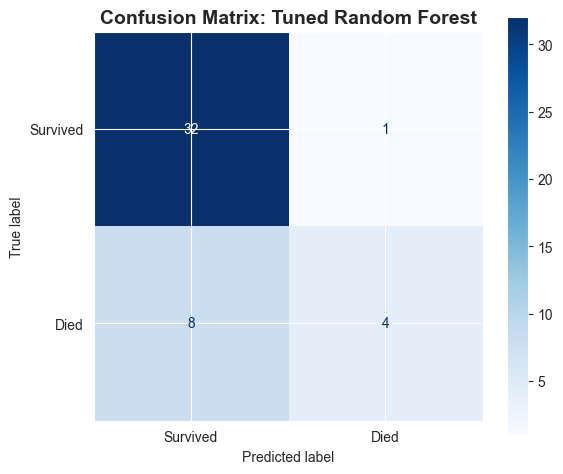


SUMMARY:
Accuracy: 0.800 | Recall: 0.333 | Precision: 0.800
F1 Score: 0.471 | ROC-AUC: 0.934
Missed Deaths (FN): 8 out of 12 (66.7%)



In [107]:
results_df = pd.DataFrame(rf_grid.cv_results_)

best_rf_model = rf_grid.best_estimator_

# Make predictions on validation set
y_val_pred_tuned_rf = best_rf_model.predict(X_val)
y_val_pred_proba_tuned_rf = best_rf_model.predict_proba(X_val)[:, 1]

# Evaluate the tuned model
evaluate_model(y_val, y_val_pred_tuned_rf, y_val_pred_proba_tuned_rf, model_name="Tuned Random Forest")

In [ ]:
# Change Threshold (since recall was poor) and evaluate
threshold = 0.225
y_pred_03 = (y_val_pred_proba_tuned_rf >= threshold).astype(int)

print("Threshold:", threshold)
print("Recall:", recall_score(y_val, y_pred_03))
print("Precision:", precision_score(y_val, y_pred_03))
print("F1:", f1_score(y_val, y_pred_03))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_03))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred_03))
print(classification_report(y_val, y_pred_03))

Threshold: 0.225
Recall: 1.0
Precision: 0.631578947368421
F1: 0.7741935483870968
ROC-AUC: 0.8939393939393939
Confusion matrix:
 [[26  7]
 [ 0 12]]
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        33
           1       0.63      1.00      0.77        12

    accuracy                           0.84        45
   macro avg       0.82      0.89      0.83        45
weighted avg       0.90      0.84      0.85        45



COMPARISON: Baseline vs Tuned Random Forest (0.5)
  Metric  Baseline  LR  Tuned DT  Improvement
 ROC-AUC      0.840909  0.934343     0.093434
  Recall      0.583333  0.333333    -0.250000
F1 Score      0.560000  0.470588    -0.089412


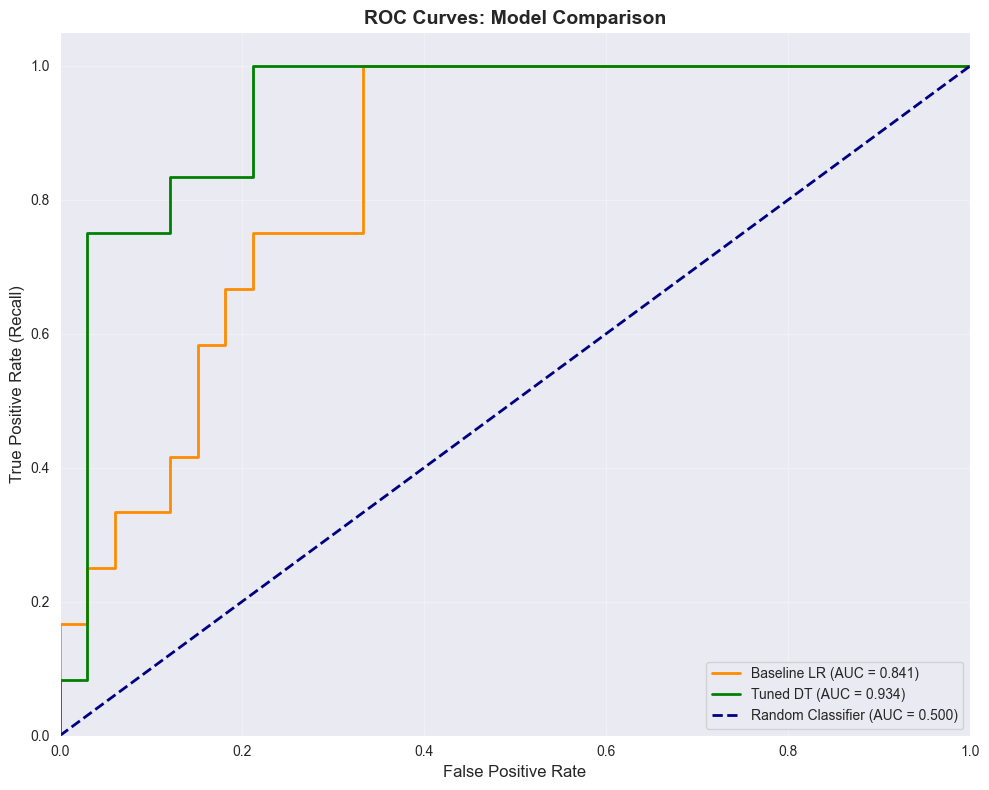

In [114]:
# Compare baseline vs tuned Random Forest
print("="*70)
print("COMPARISON: Baseline vs Tuned Random Forest (0.5)")
print("="*70)

# Calculate metrics
tuned_rf_auc = roc_auc_score(y_val, y_val_pred_proba_tuned_rf)
tuned_rf_recall = recall_score(y_val, y_val_pred_tuned_rf, pos_label=1)
tuned_rf_f1 = f1_score(y_val, y_val_pred_tuned_rf, pos_label=1)

comparison = pd.DataFrame({
    'Metric': ['ROC-AUC', 'Recall', 'F1 Score'],
    'Baseline  LR': [baseline_auc, baseline_recall, baseline_f1],
    'Tuned DT': [tuned_rf_auc, tuned_rf_recall, tuned_rf_f1],
    'Improvement': [tuned_rf_auc - baseline_auc, tuned_rf_recall - baseline_recall, tuned_rf_f1 - baseline_f1]
})

print(comparison.to_string(index=False))
print("="*70)

# Plot ROC curves side by side
models_dict = {
    'Baseline LR': y_val_pred_proba,
    'Tuned DT': y_val_pred_proba_tuned_rf
}
plot_multiple_roc_curves(models_dict, y_val)


In [117]:
# Store results for later comparison with other models
rf_results = {
    'model_name': 'Random Forest (Tuned)',
    'model': best_rf_model,
    'y_pred': y_val_pred_tuned_rf,
    'y_pred_proba': y_val_pred_proba_tuned_rf,
    'roc_auc': tuned_rf_auc,
    'recall': tuned_rf_recall,
    'f1': tuned_rf_f1,
    'best_params': rf_grid.best_params_
}

all_results['Random Forest (Tuned) (0.5)'] = rf_results

COMPARISON: Baseline vs Tuned Random Forest (0.225)
  Metric  Baseline  LR  Tuned DT  Improvement
 ROC-AUC      0.840909  0.893939     0.053030
  Recall      0.583333  1.000000     0.416667
F1 Score      0.560000  0.774194     0.214194


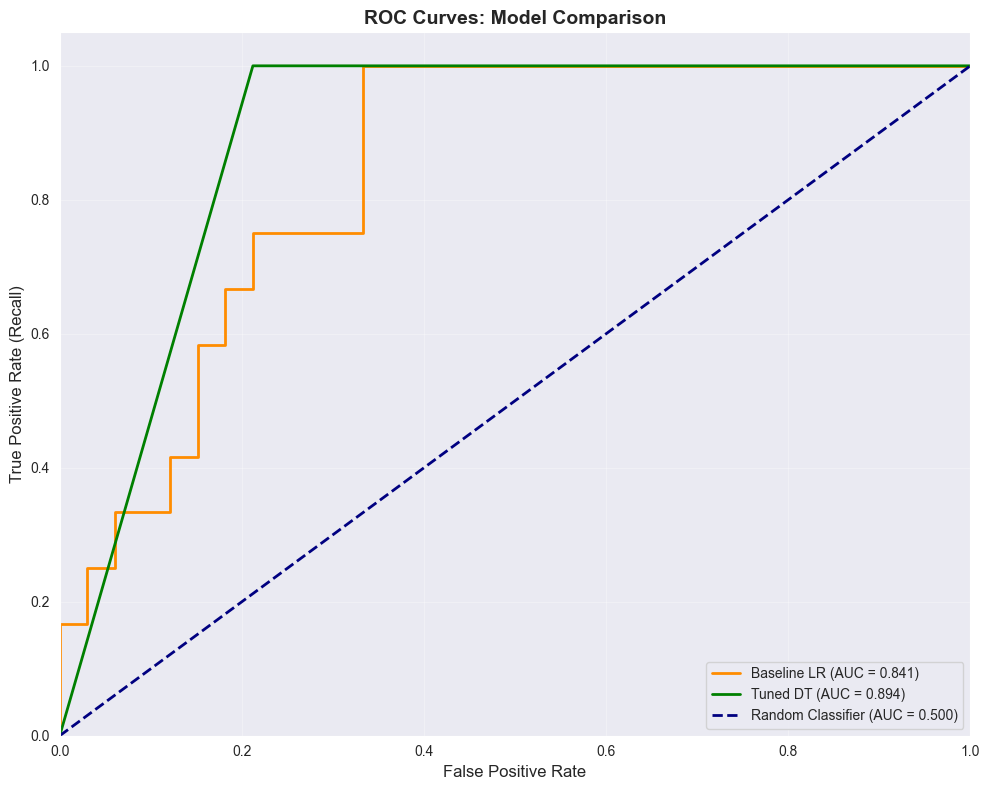

In [115]:
# Compare baseline vs tuned Random Forest
print("="*70)
print("COMPARISON: Baseline vs Tuned Random Forest (0.225)")
print("="*70)

# Calculate metrics
tuned_rf_auc = roc_auc_score(y_val, y_pred_03)
tuned_rf_recall = recall_score(y_val, y_pred_03, pos_label=1)
tuned_rf_f1 = f1_score(y_val, y_pred_03, pos_label=1)

comparison = pd.DataFrame({
    'Metric': ['ROC-AUC', 'Recall', 'F1 Score'],
    'Baseline  LR': [baseline_auc, baseline_recall, baseline_f1],
    'Tuned DT': [tuned_rf_auc, tuned_rf_recall, tuned_rf_f1],
    'Improvement': [tuned_rf_auc - baseline_auc, tuned_rf_recall - baseline_recall, tuned_rf_f1 - baseline_f1]
})

print(comparison.to_string(index=False))
print("="*70)

# Plot ROC curves side by side
models_dict = {
    'Baseline LR': y_val_pred_proba,
    'Tuned DT': y_pred_03
}
plot_multiple_roc_curves(models_dict, y_val)


In [118]:


rf_results = { 
    'model_name': 'Random Forest (Tuned) (0.225)',
    'model': best_rf_model,
    'y_pred': y_pred_03,
    'y_pred_proba': y_pred_03,
    'roc_auc': tuned_rf_auc,
    'recall': tuned_rf_recall,
    'f1': tuned_rf_f1,
}

all_results['Random Forest (Tuned) (0.225)'] = rf_results

### Gradient Boosting/XGBoost 
We will follow the same process for Gradient Boosting and XGBoost